## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.regularizers import l1, l2, l1_l2

def build_mlp_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l_ratio))(x)

    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp_batch(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp_drop(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model


In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = [1e-3, 1e-4, 1e-5]
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
MODE = ['l2','bn','drop']

In [8]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for mode in MODE:
    for learning_rate in LEARNING_RATE:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        if mode == 'l2':
            model = build_mlp_l2(input_shape=x_train.shape[1:])
        elif mode == 'bn':
            model = build_mlp_batch(input_shape=x_train.shape[1:])
        else:
            model = build_mlp_drop(input_shape=x_train.shape[1:])
        model.summary()
        optimizer = keras.optimizers.SGD(lr=learning_rate, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)
    
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
    
        exp_name_tag = "exp-l2-%s-%s" %(mode, str(learning_rate))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 143us/step - loss: 2.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 72us/step - loss: 2.3774 - acc: 0.1763 - val_loss: 2.2877 - val_acc: 0.2281
Epoch 2/50
50000/50000 [==============================] - 3s 66us/step - loss: 2.2370 - acc: 0.2565 - val_loss: 2.1933 - val_acc: 0.2734
Epoch 3/50
50000/50000 [==============================] - 3s 68us/step - loss: 2.1578 - acc: 0.2923 - val_loss: 2.1279 - val_acc: 0.3011
Epoch 4/50
50000/50000 [==============================] - 3s 67us/step - loss: 2.1034 - acc: 0.3129 - val_loss: 2.0833 - val_acc: 0.3169
Epoch 5/50
50000/50000 [==============================] - 3s 67us/step - loss: 2.0636 - acc: 0.3283 - val_loss: 2.0494 - val_acc: 0.3260
Epoch 6/50
50000/50000 [==============================] - 3s 68us/step - loss: 2.0328 - acc: 0.3393 - val_loss: 2.0237 - val_acc: 0.3388
Epoch 7/50
50000/50000 [==============================] - 3s 67us/step - loss: 2.0085 - acc: 0.3481 - val_loss: 2.0004 - val_acc

50000/50000 [==============================] - 3s 68us/step - loss: 2.4343 - acc: 0.1257 - val_loss: 2.4177 - val_acc: 0.1514
Epoch 3/50
50000/50000 [==============================] - 3s 67us/step - loss: 2.4029 - acc: 0.1559 - val_loss: 2.3937 - val_acc: 0.1725
Epoch 4/50
50000/50000 [==============================] - 3s 66us/step - loss: 2.3810 - acc: 0.1761 - val_loss: 2.3737 - val_acc: 0.1899
Epoch 5/50
50000/50000 [==============================] - 3s 67us/step - loss: 2.3620 - acc: 0.1895 - val_loss: 2.3561 - val_acc: 0.1982
Epoch 6/50
50000/50000 [==============================] - 3s 67us/step - loss: 2.3456 - acc: 0.1990 - val_loss: 2.3410 - val_acc: 0.2075
Epoch 7/50
50000/50000 [==============================] - 3s 67us/step - loss: 2.3312 - acc: 0.2079 - val_loss: 2.3271 - val_acc: 0.2149
Epoch 8/50
50000/50000 [==============================] - 3s 68us/step - loss: 2.3179 - acc: 0.2153 - val_loss: 2.3140 - val_acc: 0.2238
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 4s 86us/step - loss: 1.8659 - acc: 0.3626 - val_loss: 1.7945 - val_acc: 0.3941
Epoch 2/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.5429 - acc: 0.4604 - val_loss: 1.6568 - val_acc: 0.4134
Epoch 3/50
50000/50000 [==============================] - 4s 79us/step - loss: 1.4409 - acc: 0.4953 - val_loss: 1.5396 - val_acc: 0.4572
Epoch 4/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.3694 - acc: 0.5207 - val_loss: 1.5209 - val_acc: 0.4630
Epoch 5/50
50000/50000 [==============================] - 4s 82us/step - loss: 1.3078 - acc: 0.5438 - val_loss: 1.4970 - val_acc: 0.4765
Epoch 6/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.2578 - acc: 0.5616 - val_loss: 1.5100 - val_acc: 0.4696
Epoch 7/50
50000/50000 [==============================] - 4s 80us/step - loss: 1.2106 - acc: 0.5792 - val_loss: 1.4932 - val_acc: 0.4724
Epoch 8/50
50000/50000 [============================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 89us/step - loss: 2.2610 - acc: 0.2554 - val_loss: 2.0531 - val_acc: 0.3149
Epoch 2/50
50000/50000 [==============================] - 4s 83us/step - loss: 1.8696 - acc: 0.3542 - val_loss: 1.8539 - val_acc: 0.3650
Epoch 3/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.7534 - acc: 0.3902 - val_loss: 1.7715 - val_acc: 0.3881
Epoch 4/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.6792 - acc: 0.4133 - val_loss: 1.7225 - val_acc: 0.4018
Epoch 5/50
50000/50000 [==============================] - 4s 82us/step - loss: 1.6272 - acc: 0.4326 - val_loss: 1.6943 - val_acc: 0.4198
Epoch 6/50
50000/50000 [==============================] - 4s 82us/step - loss: 1.5852 - acc: 0.4453 - val_loss: 1.6660 - val_acc: 0.4228
Epoch 7/50
50000/50000 [==============================] - 4s 80us/step - loss: 1.5500 - acc: 0.4586 - val_loss: 1.6351 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 85us/step - loss: 2.7482 - acc: 0.1430 - val_loss: 2.4863 - val_acc: 0.1980
Epoch 2/50
50000/50000 [==============================] - 5s 90us/step - loss: 2.4159 - acc: 0.2112 - val_loss: 2.3157 - val_acc: 0.2377
Epoch 3/50
50000/50000 [==============================] - 4s 80us/step - loss: 2.2686 - acc: 0.2478 - val_loss: 2.2247 - val_acc: 0.2596
Epoch 4/50
50000/50000 [==============================] - 4s 81us/step - loss: 2.1811 - acc: 0.2699 - val_loss: 2.1592 - val_acc: 0.2754
Epoch 5/50
50000/50000 [==============================] - 4s 82us/step - loss: 2.1168 - acc: 0.2864 - val_loss: 2.1107 - val_acc: 0.2883
Epoch 6/50
50000/50000 [==============================] - 4s 81us/step - loss: 2.0669 - acc: 0.2983 - val_loss: 2.0685 - val_acc: 0.2999
Epoch 7/50
50000/50000 [==============================] - 4s 85us/step - loss: 2.0255 - acc: 0.3101 - val_loss: 2.0335 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 72us/step - loss: 2.1802 - acc: 0.1896 - val_loss: 1.9771 - val_acc: 0.3118
Epoch 2/50
50000/50000 [==============================] - 3s 68us/step - loss: 1.9721 - acc: 0.2817 - val_loss: 1.8547 - val_acc: 0.3448
Epoch 3/50
50000/50000 [==============================] - 3s 68us/step - loss: 1.8845 - acc: 0.3213 - val_loss: 1.7788 - val_acc: 0.3728
Epoch 4/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.8262 - acc: 0.3413 - val_loss: 1.7281 - val_acc: 0.3907
Epoch 5/50
50000/50000 [==============================] - 3s 67us/step - loss: 1.7809 - acc: 0.3637 - val_loss: 1.6837 - val_acc: 0.4049
Epoch 6/50
50000/50000 [==============================] - 4s 72us/step - loss: 1.7470 - acc: 0.3743 - val_loss: 1.6498 - val_acc: 0.4134
Epoch 7/50
50000/50000 [==============================] - 4s 71us/step - loss: 1.7154 - acc: 0.3868 - val_loss: 1.6247 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 72us/step - loss: 2.3073 - acc: 0.1274 - val_loss: 2.2248 - val_acc: 0.2118
Epoch 2/50
50000/50000 [==============================] - 3s 67us/step - loss: 2.2378 - acc: 0.1703 - val_loss: 2.1622 - val_acc: 0.2456
Epoch 3/50
50000/50000 [==============================] - 3s 67us/step - loss: 2.1871 - acc: 0.1980 - val_loss: 2.1075 - val_acc: 0.2694
Epoch 4/50
50000/50000 [==============================] - 3s 67us/step - loss: 2.1429 - acc: 0.2169 - val_loss: 2.0613 - val_acc: 0.2840
Epoch 5/50
50000/50000 [==============================] - 3s 67us/step - loss: 2.1091 - acc: 0.2311 - val_loss: 2.0222 - val_acc: 0.2997
Epoch 6/50
50000/50000 [==============================] - 3s 68us/step - loss: 2.0736 - acc: 0.2448 - val_loss: 1.9921 - val_acc: 0.3096
Epoch 7/50
50000/50000 [==============================] - 4s 74us/step - loss: 2.0502 - acc: 0.2508 - val_loss: 1.9680 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 71us/step - loss: 2.3725 - acc: 0.1051 - val_loss: 2.2967 - val_acc: 0.1170
Epoch 2/50
50000/50000 [==============================] - 3s 68us/step - loss: 2.3340 - acc: 0.1119 - val_loss: 2.2790 - val_acc: 0.1384
Epoch 3/50
50000/50000 [==============================] - 4s 72us/step - loss: 2.3190 - acc: 0.1191 - val_loss: 2.2672 - val_acc: 0.1517
Epoch 4/50
50000/50000 [==============================] - 3s 67us/step - loss: 2.3066 - acc: 0.1242 - val_loss: 2.2576 - val_acc: 0.1567
Epoch 5/50
50000/50000 [==============================] - 3s 66us/step - loss: 2.2965 - acc: 0.1299 - val_loss: 2.2493 - val_acc: 0.1642
Epoch 6/50
50000/50000 [==============================] - 3s 66us/step - loss: 2.2879 - acc: 0.1342 - val_loss: 2.2416 - val_acc: 0.1720
Epoch 7/50
50000/50000 [==============================] - 3s 67us/step - loss: 2.2805 - acc: 0.1424 - val_loss: 2.2341 - val_acc

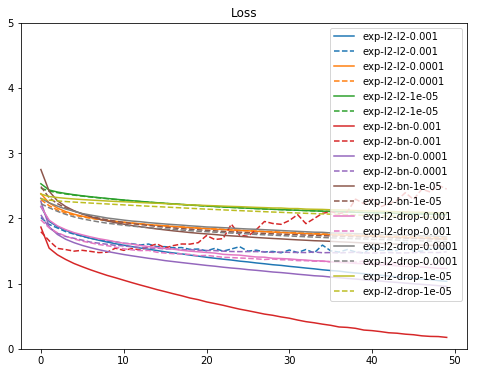

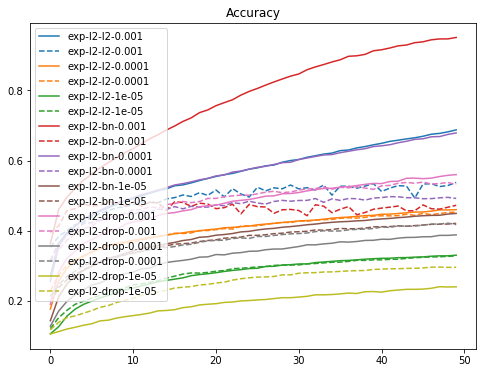

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()